<a href="https://colab.research.google.com/github/i1idan/schizophrenia-diagnosis-eeg-signals/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Clone the Repository

In [ ]:
!git clone https://github.com/i1idan/schizophrenia-diagnosis-eeg-signals.git

In [ ]:
import os
os.chdir('/content/schizophrenia-diagnosis-eeg-signals')
!git pull origin main

# Install Requirements

In [ ]:
!pip install -r requirements.txt

# Get Data

In [ ]:
!gdown --id 1jnWHWrArzJQIvny0cQkfPP42hEJAp_56
!mv DATA.mat /content/schizophrenia-diagnosis-eeg-signals/data/DATA.mat

# Training Models

In [1]:
import os
import warnings
from train import main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Number of training in a sequence
multi_train = 10
epochs = 200
model_names = ["WaveletCustom", "FFTCustom", "Transformer", "conv_lstm"]
data_path = "./data/DATA.mat"
# checkpoints = "/content/drive/MyDrive/schizophrenia/checkpoints"
checkpoints = "./checkpoints"
batch_size = 4
early_stopping = 100
reduce_lr = 50
seed = 1234

[INFO] Model:conv_lstm is loaded ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 96, 8)      48        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 92, 4)      164       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 88, 2)      42        
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, None, 88, 2)       0         
                                                                 
 time_distributed_3 (TimeDis  (None, None, 44, 2)      0         
 tributed)         

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 13s 26ms/step - loss: 0.6415 - accuracy: 0.6176 - val_loss: 0.5535 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7153

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 23ms/step - loss: 0.5695 - accuracy: 0.7153 - val_loss: 0.4531 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 3/200
210/213 [============================>.] - ETA: 0s - loss: 0.4113 - accuracy: 0.8214

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 23ms/step - loss: 0.4136 - accuracy: 0.8188 - val_loss: 0.4262 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 4/200
208/213 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8606

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.3971 - accuracy: 0.8612 - val_loss: 0.3214 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 5/200
212/213 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.8797

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 23ms/step - loss: 0.2735 - accuracy: 0.8788 - val_loss: 0.2803 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 6/200
213/213 [==============================] - 3s 12ms/step - loss: 0.1893 - accuracy: 0.9294 - val_loss: 0.3958 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 7/200
210/213 [============================>.] - ETA: 0s - loss: 0.1629 - accuracy: 0.9345

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.1613 - accuracy: 0.9353 - val_loss: 0.1278 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 8/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0747 - accuracy: 0.9694 - val_loss: 0.1321 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 9/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0939 - accuracy: 0.9718 - val_loss: 0.2253 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 10/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0683 - accuracy: 0.9776 - val_loss: 0.3538 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 11/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0791 - accuracy: 0.9659 - val_loss: 0.1436 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 12/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0502 - accuracy: 0.9847 - val_loss: 0.1454 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 13/200
213/213 [==============================] - 2s 11ms/ste

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.0505 - accuracy: 0.9788 - val_loss: 0.0754 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 16/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.1967 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 17/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.1304 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 18/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.2468 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 19/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.1719 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 20/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0544 - accuracy: 0.9776 - val_loss: 0.1520 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 21/200
211/213 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0692 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 22/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.1658 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 23/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0292 - accuracy: 0.9871 - val_loss: 0.2837 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 24/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0308 - accuracy: 0.9918 - val_loss: 0.1300 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 25/200
211/213 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9976

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0656 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 26/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.1046 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 27/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0288 - accuracy: 0.9929 - val_loss: 0.2362 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 28/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0293 - accuracy: 0.9894 - val_loss: 0.1852 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 29/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0351 - accuracy: 0.9859 - val_loss: 0.2498 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 30/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.1966 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 31/200
213/213 [==============================] - 2s 11ms/s

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 23ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0327 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 75/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9965 - val_loss: 0.1579 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 76/200
213/213 [==============================] - 2s 11ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.1049 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 77/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.1147 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 78/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0060 - accuracy: 0.9965 - val_loss: 0.1947 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 79/200
213/213 [==============================] - 3s 13ms/step - loss: 0.0039 - accuracy: 0.9976 - val_loss: 0.1185 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 80/200
213/213 [==============================] - 3s 13ms/s

INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


INFO:tensorflow:Assets written to: ./checkpoints/conv_lstm/0\model_best\assets


213/213 [==============================] - 5s 22ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0311 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 87/200
213/213 [==============================] - 3s 14ms/step - loss: 3.9800e-04 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 88/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 0.2396 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 89/200
213/213 [==============================] - 2s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.1774 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 90/200
213/213 [==============================] - 3s 12ms/step - loss: 4.5466e-04 - accuracy: 1.0000 - val_loss: 0.2181 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 91/200
213/213 [==============================] - 3s 12ms/step - loss: 9.2350e-04 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 92/200
213/213 [==============================]

Epoch 137/200
213/213 [==============================] - 3s 12ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.1421 - val_accuracy: 0.9720 - lr: 5.0000e-04
Epoch 138/200
213/213 [==============================] - 2s 12ms/step - loss: 4.3886e-04 - accuracy: 1.0000 - val_loss: 0.1565 - val_accuracy: 0.9720 - lr: 5.0000e-04
Epoch 139/200
213/213 [==============================] - 2s 12ms/step - loss: 1.2983e-04 - accuracy: 1.0000 - val_loss: 0.1647 - val_accuracy: 0.9720 - lr: 5.0000e-04
Epoch 140/200
213/213 [==============================] - 3s 12ms/step - loss: 6.5054e-04 - accuracy: 1.0000 - val_loss: 0.2069 - val_accuracy: 0.9626 - lr: 5.0000e-04
Epoch 141/200
213/213 [==============================] - 2s 12ms/step - loss: 6.9182e-05 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9626 - lr: 5.0000e-04
Epoch 142/200
213/213 [==============================] - 2s 11ms/step - loss: 5.4869e-04 - accuracy: 1.0000 - val_loss: 0.2358 - val_accuracy: 0.9626 - lr: 5.0000e-04
Ep

213/213 [==============================] - ETA: 0s - loss: 4.8200e-06 - accuracy: 1.0000
Epoch 00186: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
213/213 [==============================] - 5s 22ms/step - loss: 4.8200e-06 - accuracy: 1.0000 - val_loss: 0.2181 - val_accuracy: 0.9720 - lr: 5.0000e-04
Epoch 00186: early stopping
[INFO] confusion matrix:!
[INFO] Loading best model:
7/7 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       106
         1.0       0.98      1.00      0.99       108

    accuracy                           0.99       214
   macro avg       0.99      0.99      0.99       214
weighted avg       0.99      0.99      0.99       214

[INFO] Computing Confusion matrix
conf_matrix.jpg is successfully saved!
-----------------------------train 0 is done! ----------------------------------


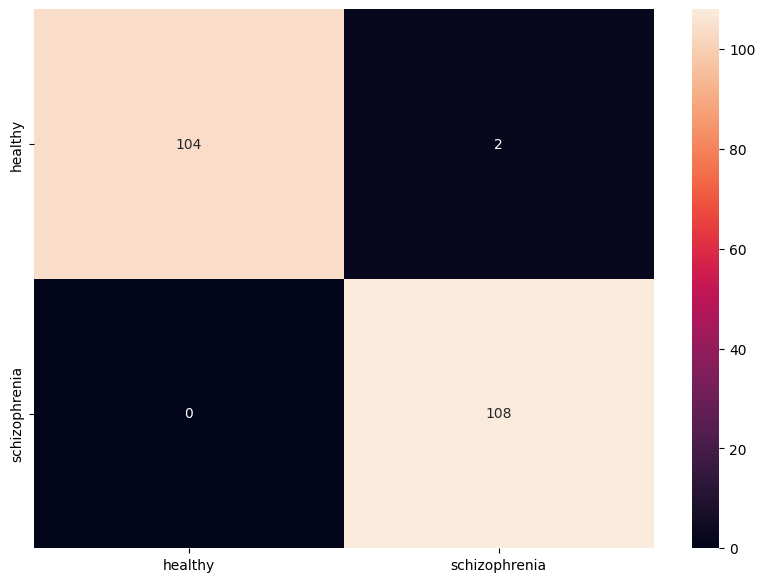

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# suppress warnings:
warnings.filterwarnings("ignore")

for model_name in model_names:
    for n in range(multi_train):
        dir_name = f"{n}"
        new_seed = seed + n
        # preserve reproducibility
        #     !PYTHONHASHSEED=0
        #     !TF_DETERMINISTIC_OPS=0
        #     !TF_CUDNN_DETERMINISTIC=0
        main(model_name=model_name, epochs=epochs, seed=new_seed,
             dir_name=dir_name, checkpoints=checkpoints, batch_size=batch_size)
        print(f"-----------------------------train {n} is done! ----------------------------------")

# Get Metrics

In [6]:
from utils.group_metrics import get_mean_std
import os
for model_name in model_names:
    print(f"[INFO] Processing Model: {model_name}")
    csv_files = [os.path.join(checkpoints, model_name ,f"{n}", "log.csv") for n in range(multi_train)]
    metrics = get_mean_std(csv_files, 
                       arguments=("accuracy", "loss", "val_accuracy", "val_loss"),
                       operators=(max, min, max, min)
                      )
    print(model_name, "\n", metrics)

[INFO] Processing Model: WaveletCustom
[INFO] Extracting values from csv files...
[INFO] Getting the values of file ./checkpoints\WaveletCustom\0\log.csv
WaveletCustom 
 {'accuracy': {'std': 0.0, 'mean': 1.0}, 'loss': {'std': 0.0, 'mean': 0.0001}, 'val_accuracy': {'std': 0.0, 'mean': 0.8738}, 'val_loss': {'std': 0.0, 'mean': 0.5344}}
[INFO] Processing Model: FFTCustom
[INFO] Extracting values from csv files...
[INFO] Getting the values of file ./checkpoints\FFTCustom\0\log.csv
FFTCustom 
 {'accuracy': {'std': 0.0, 'mean': 1.0}, 'loss': {'std': 0.0, 'mean': 0.0001}, 'val_accuracy': {'std': 0.0, 'mean': 0.8738}, 'val_loss': {'std': 0.0, 'mean': 0.4156}}
[INFO] Processing Model: Transformer
[INFO] Extracting values from csv files...
[INFO] Getting the values of file ./checkpoints\Transformer\0\log.csv
Transformer 
 {'accuracy': {'std': 0.0, 'mean': 1.0}, 'loss': {'std': 0.0, 'mean': 0.0}, 'val_accuracy': {'std': 0.0, 'mean': 1.0}, 'val_loss': {'std': 0.0, 'mean': 0.0}}
[INFO] Processing M

# Get Sensitivity & Specificity

In [7]:
from utils.group_metrics import get_conf_mean_std
import os
for model_name in model_names:
    print(f"[INFO] Processing {model_name}")
    conf_matrixes = [os.path.join(checkpoints, model_name ,f"{n}", "conf_matrix.csv") for n in range(multi_train)]

    metrics = get_conf_mean_std(conf_matrixes)
    print(model_name, "\n", metrics)

[INFO] Processing WaveletCustom
[INFO] Extracting values from confusion matrices
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\0\conf_matrix.csv
[INFO] Successfully Extracted dict_keys(['sensitivity', 'specificity', 'accuracy', 'f1_score'])
WaveletCustom 
 {'sensitivity': {'std': 0.0, 'mean': 0.75}, 'specificity': {'std': 0.0, 'mean': 0.7453}, 'accuracy': {'std': 0.0, 'mean': 0.7477}, 'f1_score': {'std': 0.0, 'mean': 0.75}}
[INFO] Processing FFTCustom
[INFO] Extracting values from confusion matrices
[INFO] Getting the values of df: ./checkpoints\FFTCustom\0\conf_matrix.csv
[INFO] Successfully Extracted dict_keys(['sensitivity', 'specificity', 'accuracy', 'f1_score'])
FFTCustom 
 {'sensitivity': {'std': 0.0, 'mean': 0.8901}, 'specificity': {'std': 0.0, 'mean': 0.7805}, 'accuracy': {'std': 0.0, 'mean': 0.8271}, 'f1_score': {'std': 0.0, 'mean': 0.8141}}
[INFO] Processing Transformer
[INFO] Extracting values from confusion matrices
[INFO] Getting the values of df: ./checkpoi

In [3]:
from delong_test import delong_test_fn
output_z = np.zeros((len(model_names), len(model_names)))
output_p = np.zeros((len(model_names), len(model_names)))
train_n = 0
for f_e, f in enumerate(model_names):
    for s_e, s in enumerate(model_names):
        df1 = pd.read_csv(os.path.join(checkpoints, f , f"{train_n}", "y_test_pred.csv"))
        df2 = pd.read_csv(os.path.join(checkpoints, s , f"{train_n}", "y_test_pred.csv"))
        assert np.all(df1['y_test'].values == df2['y_test'].values)
        z, p = delong_test_fn(df1['y_test'].values, df1['y_pred'].values, df2['y_pred'].values)
        output_p[f_e, s_e] = p
        output_z[f_e, s_e] = z

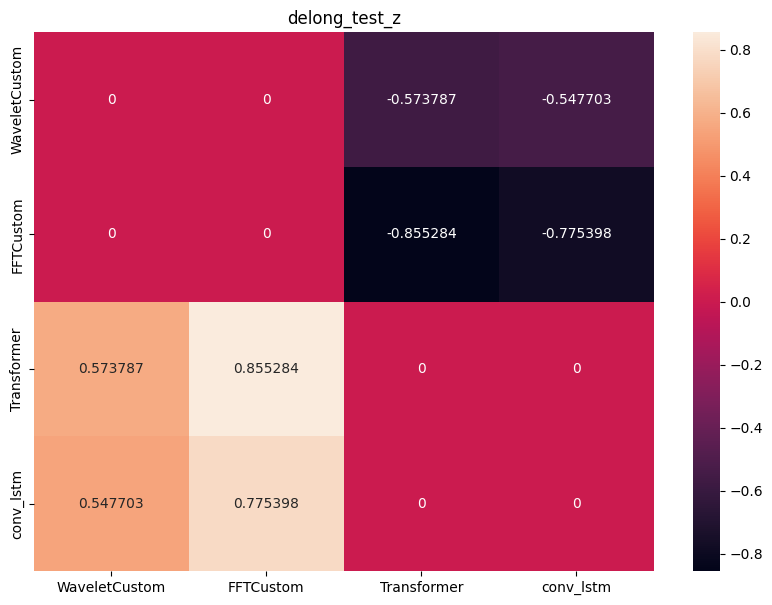

In [4]:
df_cm = pd.DataFrame(output_z, index=model_names, columns=model_names)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("delong_test_z")
plt.xlabel("")
plt.ylabel("")
plt.savefig('delong_test_z.png')
plt.show()

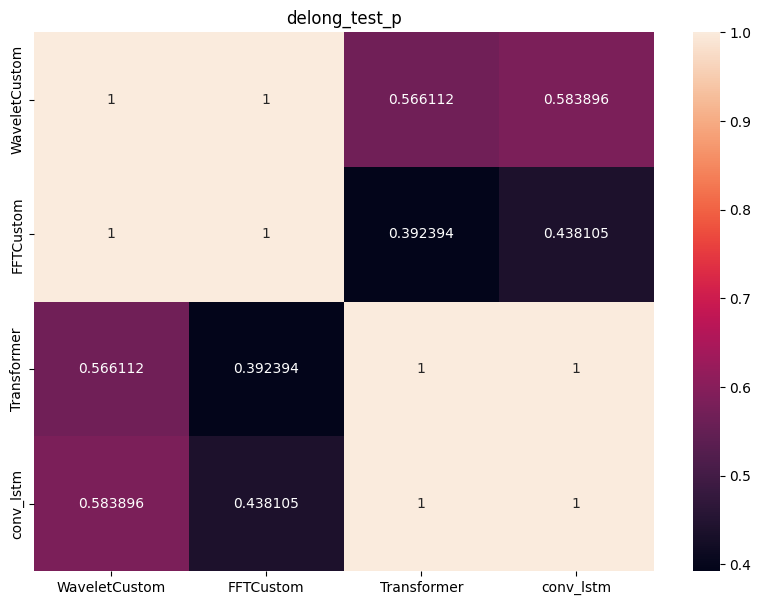

In [5]:
df_cm = pd.DataFrame(output_p, index=model_names, columns=model_names)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("delong_test_p")
plt.xlabel("")
plt.ylabel("")
plt.savefig('delong_test_p.png')
plt.show()

_:)_